**Import**

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import patches
from scipy import signal
import cv2
import numpy as np
from skimage.feature import greycomatrix, greycoprops
from skimage import data
from PIL import Image
from skimage.io import imread,imshow
from skimage import morphology
from scipy.stats import skew, kurtosis,entropy
import os
import csv

**Connect to Drive For GOOGLE DRIVE**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**CLAHE**

In [ ]:
def prebpicture(bgr):	
  bgr = cv2.resize(bgr, (256, 256))
  lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
  lab_planes = cv2.split(lab)
  clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))
  lab_planes[0] = clahe.apply(lab_planes[0])
  lab = cv2.merge(lab_planes)
  bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  #save image to temp file
  #cv2.imwrite('/content/drive/MyDrive/Dataset/temp/clahe-output.jpg',bgr)
  return bgr


**SEGMENT CUP AND DISC**
ref : https://github.com/jahin07/optic-cup-disc

In [ ]:
def segment_cd(image,plotHis,plotPic):
  #PRE-PROCESSING AND SMOOTHING

  Abo,Ago,Aro = cv2.split(image)  #splitting into 3 colors


  Ar = Aro - Aro.mean()           #Preprocessing Red
  Ar = Ar - Ar.mean() - Aro.std() #Preprocessing Red
  Ar = Ar - Ar.mean() - Aro.std() #Preprocessing Red

  Mr = Ar.mean()                           #Mean of preprocessed red
  SDr = Ar.std()                           #SD of preprocessed red
  Thr = 49.5 - 12 - Ar.std()               #OD Threshold


  Ag = Ago - Ago.mean()           #Preprocessing Green
  Ag = Ag - Ag.mean() - Ago.std() #Preprocessing Green

  Mg = Ag.mean()                           #Mean of preprocessed green
  SDg = Ag.std()                           #SD of preprocessed green
  Thg = Ag.mean() + 2*Ag.std() + 49.5 + 12 #OC Threshold

  filter = signal.gaussian(99, std=6) #Gaussian Window
  filter=filter/sum(filter)

  hist,bins = np.histogram(Ag.ravel(),256,[0,256])   #Histogram of preprocessed green channel
  histr,binsr = np.histogram(Ar.ravel(),256,[0,256]) #Histogram of preprocessed red channel

  smooth_hist_g=np.convolve(filter,hist)  #Histogram Smoothing Green
  smooth_hist_r=np.convolve(filter,histr) #Histogram Smoothing Red

  if plotHis:
    plt.subplot(2, 2, 1)
    plt.plot(hist)
    plt.title("Preprocessed Green Channel")

    plt.subplot(2, 2, 2)
    plt.plot(smooth_hist_g)
    plt.title("Smoothed Histogram Green Channel")

    plt.subplot(2, 2, 3)
    plt.plot(histr)
    plt.title("Preprocessed Red Channel")

    plt.subplot(2, 2, 4)
    plt.plot(smooth_hist_r)
    plt.title("Smoothed Histogram Red Channel")

    plt.show()

  #APPLYING THRESHOLD

  r,c = Ag.shape
  Dd = np.zeros(shape=(r,c))
  Dc = np.zeros(shape=(r,c))

  for i in range(1,r):
    for j in range(1,c):
      if Ar[i,j]>Thr:
        Dd[i,j]=255
      else:
        Dd[i,j]=0

  for i in range(1,r):
    for j in range(1,c):
      if Ag[i,j]>Thg:
        Dc[i,j]=1
      else:
        Dc[i,j]=0

  #DISPLAYING SEGMENTED OPTIC DISK AND CUP
  if plotPic:
    plt.imshow(Dd, cmap = 'gray', interpolation = 'bicubic')
    plt.axis("off")
    plt.title("Optic Disk")
    plt.show()

    plt.imshow(Dc, cmap = 'gray', interpolation = 'bicubic')
    plt.axis("off")
    plt.title("Optic Cup")
    plt.show()		

  #save image to temp file

  #cv2.imwrite('/content/drive/MyDrive/Dataset/temp/disk.png',Dd)
  #plt.imsave('/content/drive/MyDrive/Dataset/temp/cup.png',Dc , cmap='gray')



**CDR** ref : https://github.com/NupurBhaisare/Cup-and-disc-segmentation-for-glaucoma-detection-CDR-Calculation-

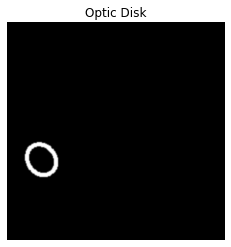

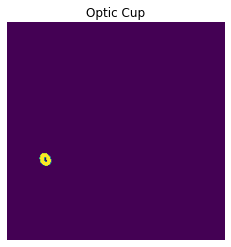

0.3170731707317073

In [ ]:
def cdr(cup,disc,plot):
  
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(10,10))
    #morphological closing and opening operations
    R1 = cv2.morphologyEx(cup, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2)), iterations = 1)
    r1 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)), iterations = 1)
    R2 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,21)), iterations = 1)
    r2 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(21,1)), iterations = 1)
    R3 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(33,33)), iterations = 1)	
    r3 = cv2.morphologyEx(R3, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(43,43)), iterations = 1)

    img = clahe.apply(r3)
    
    
    ret,thresh = cv2.threshold(cup,127,255,0)
    contours,hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) #Getting all possible contours in the segmented image
    cup_diameter = 0
    largest_area = 0
    el_cup = contours[0]
    if len(contours) != 0:
        for i in range(len(contours)):
            if len(contours[i]) >= 5:
                area = cv2.contourArea(contours[i]) #Getting the contour with the largest area
                if (area>largest_area):
                    largest_area=area
                    index = i
                    el_cup = cv2.fitEllipse(contours[i])
                
    cv2.ellipse(img,el_cup,(140,60,150),3)  #fitting ellipse with the largest area
    x,y,w,h = cv2.boundingRect(contours[index]) #fitting a rectangle on the ellipse to get the length of major axis
    cup_diameter = max(w,h) #major axis is the diameter

    #morphological closing and opening operations
    R1 = cv2.morphologyEx(disc, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2)), iterations = 1)
    r1 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)), iterations = 1)
    R2 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,21)), iterations = 1)
    r2 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(21,1)), iterations = 1)
    R3 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(33,33)), iterations = 1)
    r3 = cv2.morphologyEx(R3, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(43,43)), iterations = 1)

    img2 = clahe.apply(r3)
    
    ret,thresh = cv2.threshold(disc,127,255,0)
    contours,hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) #Getting all possible contours in the segmented image
    disk_diameter = 0
    largest_area = 0
    el_disc = el_cup
    if len(contours) != 0:
          for i in range(len(contours)):
            if len(contours[i]) >= 5:
                area = cv2.contourArea(contours[i]) #Getting the contour with the largest area
                if (area>largest_area):
                    largest_area=area
                    index = i
                    el_disc = cv2.fitEllipse(contours[i])
                    
    cv2.ellipse(img2,el_disc,(140,60,150),3) #fitting ellipse with the largest area
    x,y,w,h = cv2.boundingRect(contours[index]) #fitting a rectangle on the ellipse to get the length of major axis
    disk_diameter = max(w,h) #major axis is the diameter
                
    if plot:
        plt.imshow(img2, cmap = 'gray', interpolation = 'bicubic')
        plt.axis("off")
        plt.title("Optic Disk")
        plt.show()
        plt.imshow(img)
        plt.axis("off")
        plt.title("Optic Cup")
        plt.show()   
    if(disk_diameter == 0): return 1 # if disc not segmented properly then cdr might be infinity
    cdr = cup_diameter/disk_diameter #ration of major axis of cup and disc
    cv2.imwrite('/content/drive/MyDrive/Dataset/test Augment dont mind it/disk_forRatio.png',img2)
    plt.imsave('/content/drive/MyDrive/Dataset/test Augment dont mind it/cup_forRatio.png',img)
    return cdr
img_disk = cv2.imread('/content/drive/MyDrive/Dataset/test Augment dont mind it/disk.png',0)
img_cup = cv2.imread('/content/drive/MyDrive/Dataset/test Augment dont mind it/cup.png',0)
cdr_cal = cdr(img_cup,img_disk,True)
cdr_cal

**MA** ref : https://github.com/getsanjeev/retina-features

In [ ]:
def adjust_gamma(image, gamma=1.0):

   
   table = np.array([((i / 255.0) ** gamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

   return cv2.LUT(image, table)
def extract_ma(image):
    r,g,b=cv2.split(image)
    comp=255-g
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
    histe=clahe.apply(comp)
    adjustImage = adjust_gamma(histe,gamma=3)
    comp = 255-adjustImage
    J =  adjust_gamma(comp,gamma=4)
    J = 255-J
    J = adjust_gamma(J,gamma=4)
    
    K=np.ones((11,11),np.float32)
    L = cv2.filter2D(J,-1,K)
    
    ret3,thresh2 = cv2.threshold(L,125,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    kernel2=np.ones((9,9),np.uint8)
    tophat = cv2.morphologyEx(thresh2, cv2.MORPH_TOPHAT, kernel2)
    kernel3=np.ones((7,7),np.uint8)
    opening = cv2.morphologyEx(tophat, cv2.MORPH_OPEN, kernel3)
    return opening


**GLCM** ref : https://github.com/tzm030329/GLCM

In [ ]:
def fast_glcm(img, vmin=0, vmax=255, nbit=8, kernel_size=5):
    mi, ma = vmin, vmax
    ks = kernel_size
    h,w = img.shape

    # digitize
    bins = np.linspace(mi, ma+1, nbit+1)
    gl1 = np.digitize(img, bins) - 1
    gl2 = np.append(gl1[:,1:], gl1[:,-1:], axis=1)

    # make glcm
    glcm = np.zeros((nbit, nbit, h, w), dtype=np.uint8)
    for i in range(nbit):
        for j in range(nbit):
            mask = ((gl1==i) & (gl2==j))
            glcm[i,j, mask] = 1

    kernel = np.ones((ks, ks), dtype=np.uint8)
    for i in range(nbit):
        for j in range(nbit):
            glcm[i,j] = cv2.filter2D(glcm[i,j], -1, kernel)

    glcm = glcm.astype(np.float32)
    return glcm


def fast_glcm_mean(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm mean
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    mean = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            mean += glcm[i,j] * i / (nbit)**2

    return mean


def fast_glcm_std(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm std
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    mean = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            mean += glcm[i,j] * i / (nbit)**2

    std2 = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            std2 += (glcm[i,j] * i - mean)**2

    std = np.sqrt(std2)
    return std


def fast_glcm_contrast(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm contrast
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    cont = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            cont += glcm[i,j] * (i-j)**2

    return cont


def fast_glcm_dissimilarity(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm dissimilarity
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    diss = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            diss += glcm[i,j] * np.abs(i-j)

    return diss


def fast_glcm_homogeneity(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm homogeneity
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    homo = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            homo += glcm[i,j] / (1.+(i-j)**2)

    return homo


def fast_glcm_ASM(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm asm, energy
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    asm = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            asm  += glcm[i,j]**2

    ene = np.sqrt(asm)
    return asm, ene


def fast_glcm_max(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm max
    '''
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    max_  = np.max(glcm, axis=(0,1))
    return max_


def fast_glcm_entropy(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm entropy
    '''
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    pnorm = glcm / np.sum(glcm, axis=(0,1)) + 1./ks**2
    ent  = np.sum(-pnorm * np.log(pnorm), axis=(0,1))
    return ent